In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
from tqdm import tqdm
import requests
import shutil
import dlib

## FIFA 22 complete player dataset

https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset

In [102]:
# %%
data_path = 'dataset'
data_imgs_path = f'{data_path}/imgs'
model_path = 'model'
pretrained_arcface_model = f'{model_path}/model.tflite'
model_name = f'{model_path}/face-reader-soccer.h5'
x_data_filename = 'x_data_file.pickle'
y_data_filename = 'y_data_file.pickle'

if not os.path.exists(data_path):
    os.makdirs(data_path)
if not os.path.exists(data_imgs_path):
    os.makdirs(data_imgs_path)
if not os.path.exists(model_path):
    os.makdirs(model_path)

In [103]:
if os.path.exists(f'{data_path}/players_22.csv'):
    print(f'{data_path}/players_22.csv exists.')
else:
    !wget https://github.com/kairess/toy-datasets/raw/master/players_22.csv -O {data_path}/players_22.csv

df = pd.read_csv(f'{data_path}/players_22.csv')

dataset/players_22.csv exists.


/home/jaerock/anaconda3/envs/face-reader-soccer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [104]:
df

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,261962,https://sofifa.com/player/261962/defu-song/220002,Song Defu,宋德福,CDM,47,52,70000.0,1000.0,22,...,46+2,46+2,46+2,48+2,15+2,https://cdn.sofifa.net/players/261/962/22_120.png,https://cdn.sofifa.net/teams/112541/60.png,https://cdn.sofifa.net/flags/cn.png,NaN,https://cdn.sofifa.net/flags/cn.png
19235,262040,https://sofifa.com/player/262040/caoimhin-port...,C. Porter,Caoimhin Porter,CM,47,59,110000.0,500.0,19,...,44+2,44+2,44+2,48+2,14+2,https://cdn.sofifa.net/players/262/040/22_120.png,https://cdn.sofifa.net/teams/445/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png
19236,262760,https://sofifa.com/player/262760/nathan-logue/...,N. Logue,Nathan Logue-Cunningham,CM,47,55,100000.0,500.0,21,...,45+2,45+2,45+2,47+2,12+2,https://cdn.sofifa.net/players/262/760/22_120.png,https://cdn.sofifa.net/teams/111131/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png
19237,262820,https://sofifa.com/player/262820/luke-rudden/2...,L. Rudden,Luke Rudden,ST,47,60,110000.0,500.0,19,...,26+2,26+2,26+2,32+2,15+2,https://cdn.sofifa.net/players/262/820/22_120.png,https://cdn.sofifa.net/teams/111131/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png


In [105]:
son = df.loc[df['short_name'] == 'H. Son']
#df.iloc[son_id]
son_idx = son.index[0]
df.iloc[son_idx]

sofifa_id                                                      200104
player_url          https://sofifa.com/player/200104/heung-min-son...
short_name                                                     H. Son
long_name                                                     손흥민 孙兴慜
player_positions                                           LM, CF, LW
                                          ...                        
player_face_url     https://cdn.sofifa.net/players/200/104/22_120.png
club_logo_url                  https://cdn.sofifa.net/teams/18/60.png
club_flag_url                 https://cdn.sofifa.net/flags/gb-eng.png
nation_logo_url                                                   NaN
nation_flag_url                   https://cdn.sofifa.net/flags/kr.png
Name: 13, Length: 110, dtype: object

In [106]:
df.iloc[son_idx]['wage_eur'] # 주급(유로)

220000.0

In [107]:
df.iloc[son_idx]['overall'] # player current overall attribute 플레이어 종합 점수

89

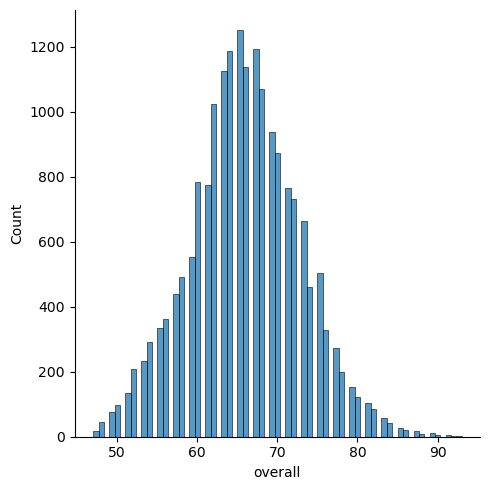

In [108]:
sns.displot(df['overall'])

## Face image download

will take 40 minutes

In [109]:
def download_face_images(data_imgs_path):
    if os.path.exists(data_imgs_path) is False:
        os.makedirs(data_imgs_path, exist_ok=True)

        for i, row in tqdm(df.iterrows()):
            img_url = row['player_face_url']
            overall = row['overall']

            r = requests.get(img_url, stream=True, headers={'User-agent': 'Mozilla/5.0'})

            if r.status_code == 200:
                with open('imgs/%s_%s.png' % (i, overall), 'wb') as f:
                    r.raw.decode_content = True
                    shutil.copyfileobj(r.raw, f)
            else:
                print(row['short_name'])
    else:
        print(f'{data_imgs_path} folder already exists.')

In [110]:
download_face_images(data_imgs_path)

dataset/imgs folder already exists.


## Arcface face recognition package

https://pypi.org/project/arcface

In [111]:
!pip install -q arcface

## Face recognition

In [112]:
from glob import glob

img_list = sorted(glob(f'{data_imgs_path}/*.png'))
img_list[:5]

['dataset/imgs/0_93.png',
 'dataset/imgs/10000_65.png',
 'dataset/imgs/10001_65.png',
 'dataset/imgs/10002_65.png',
 'dataset/imgs/10003_65.png']

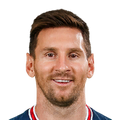

In [113]:
from PIL import Image

Image.open(img_list[0])

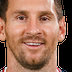

In [114]:
detector = dlib.get_frontal_face_detector()

img = Image.open(img_list[0]).convert('RGB')

dets = detector(np.array(img))
det = dets[0]

x1 = det.left()
y1 = det.top()
x2 = det.right()
y2 = det.bottom()

crop_img = img.crop((x1, y1, x2, y2))
crop_img.save('temp_crop.jpg')

crop_img

In [115]:
from arcface import ArcFace

face_rec = ArcFace.ArcFace(model_path='model/model.tflite')

emb = face_rec.calc_emb('temp_crop.jpg')

emb.shape

(512,)

In [116]:
emb

array([ 8.39622878e-03,  5.42944111e-02, -1.64493546e-02,  2.81345230e-02,
       -8.71841703e-03, -3.02846525e-02, -2.69375462e-03, -5.04671447e-02,
       -6.68199211e-02,  4.41920757e-02,  1.82662345e-02, -3.16633172e-02,
       -2.48436667e-02,  2.96484772e-02, -4.19755876e-02, -7.01596513e-02,
        9.94255021e-03,  1.06930230e-02,  3.38300988e-02,  8.82377923e-02,
       -5.86086288e-02,  4.52159978e-02,  1.92644708e-02,  4.37164456e-02,
       -1.15139233e-02, -1.11025788e-01,  3.30261104e-02,  3.48119214e-02,
        4.78399098e-02,  1.35341939e-02,  6.90466166e-02,  1.04683815e-02,
        4.62168865e-02, -5.67494892e-02,  4.32376787e-02,  7.10612815e-03,
       -2.79928204e-02,  1.86600350e-02, -6.90637380e-02,  1.56461243e-02,
       -3.83528396e-02,  1.24043655e-02, -4.26415019e-02, -4.24064100e-02,
        3.18577439e-02, -5.08735105e-02, -5.11495061e-02, -6.11916035e-02,
       -3.82698327e-02,  9.15509611e-02,  5.53657264e-02, -2.18716962e-03,
        2.04838347e-02,  

## Dataset creation

This will take 20 minutes.

In [117]:
import pickle
import os

if os.path.exists(x_data_filename) is True:
    x_data_file = open(x_data_filename, 'rb')
    x_data = pickle.load(x_data_file)
    x_data_file.close()

    y_data_file = open(y_data_filename, 'rb')
    y_data = pickle.load(y_data_file)
    y_data_file.close()
else:

    img_list = glob(f'{data_imgs_path}/*.png')

    x_data = np.zeros((len(img_list), 512), dtype=np.float32)
    y_data = np.zeros((len(img_list), 1), dtype=np.float32)

    det_failed = 0
    for i, img_path in tqdm(enumerate(img_list)):
        img = Image.open(img_path).convert('RGB')

        dets = detector(np.array(img))

        if len(dets) == 0:
            # let's count how many detection failed.
            #print('failed in detection.')
            det_failed += 1
            continue

        det = dets[0]
        x1 = det.left()
        y1 = det.top()
        x2 = det.right()
        y2 = det.bottom()

        crop_img = img.crop((x1, y1, x2, y2))
        crop_img.save('temp_crop.jpg')

        emb = face_rec.calc_emb('temp_crop.jpg')

        overall = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[1])

        x_data[i] = emb
        y_data[i] = overall

    print("Face detection failed", det_failed, "times.")
    print(x_data.shape)
    print(y_data.shape)

    x_data_file = open(x_data_filename, 'wb')
    pickle.dump(x_data, x_data_file)
    x_data_file.close()

    y_data_file = open(y_data_filename, 'wb')
    pickle.dump(y_data, y_data_file)
    y_data_file.close()

In [118]:
x_data

array([[-2.17217952e-02,  4.78682779e-02,  5.89070432e-02, ...,
         2.82913152e-05,  5.23255244e-02, -3.85520309e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.02954163e-02, -5.53480461e-02, -2.09330861e-02, ...,
         9.66490805e-03, -4.03317697e-02, -4.41561379e-02],
       ...,
       [ 2.99118552e-03, -1.01174405e-02, -3.12090963e-02, ...,
         3.46333943e-02,  1.39850297e-03, -8.71413015e-03],
       [ 2.18374413e-02, -7.42775872e-02, -4.73538646e-03, ...,
        -4.05535959e-02,  1.14587611e-02, -7.88668990e-02],
       [-4.37698103e-02, -2.84812059e-02, -6.38860161e-04, ...,
        -1.43781463e-02, -9.29635540e-02, -3.77382711e-02]], dtype=float32)

## Training/validation data split

In [119]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(15391, 512) (15391, 1)
(3848, 512) (3848, 1)


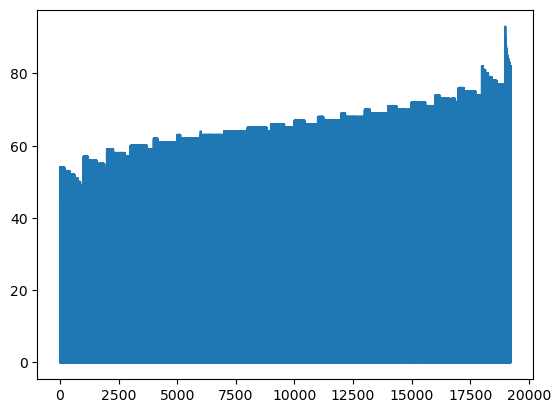

In [120]:
plt.plot(y_data)
plt.show()

## Model definition

- input: face embedding vector
- output: player's overall score

In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Check if the model has been trained and saved.

In [122]:
model_loaded = False
retrain = False # if you want to retrain the model, change this to True

if retrain is False and os.path.exists(model_name) is True:
    model = keras.models.load_model(model_name)
    model.summary()
    model_loaded = True


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


In [123]:
if retrain is True and model_loaded is False:
    model = keras.Sequential([
        layers.Dense(256, input_shape=(512,), activation="relu"),
        layers.Dense(1),
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    model.summary()

## Training

In [124]:
if retrain is True and model_loaded is False:
    history = model.fit(
        x_train,
        y_train,
        batch_size=256,
        epochs=200,
        validation_data=(x_val, y_val)
    )

    model.save(model_name)

    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
else:
    print('A trained model was already loaded.')

A trained model was already loaded.


## Test with an image

In [125]:
# %%
test_img_path = 'test_images'
test_img_list = glob(f'{test_img_path}/??.jpg')

#plt.figure()
for image in test_img_list:
    img = Image.open(image)

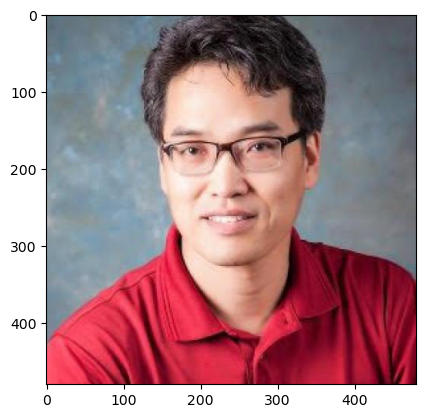

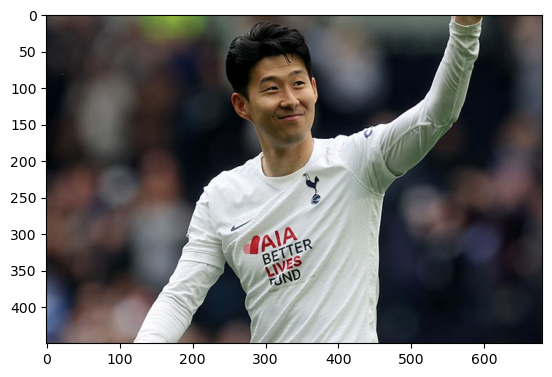

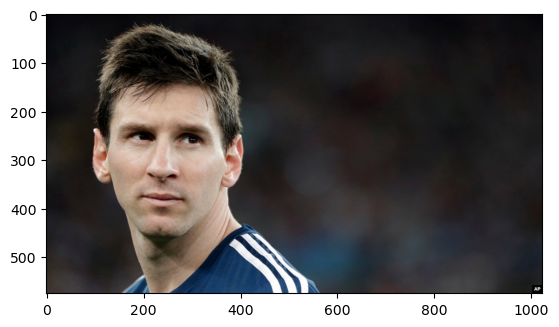

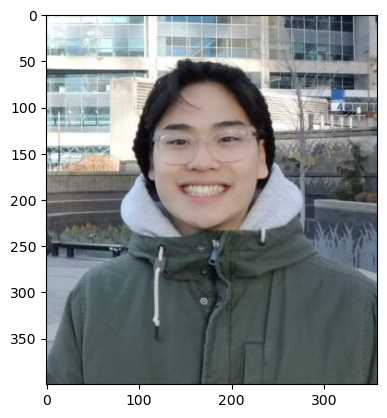

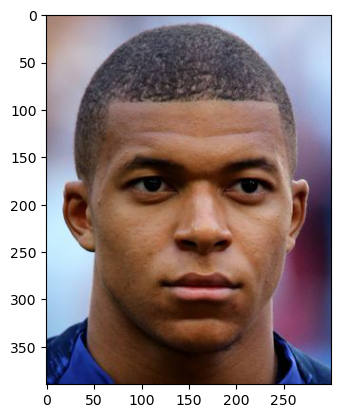

In [126]:
for image in test_img_list:
    img = Image.open(image)
    plt.figure()
    plt.imshow(img)

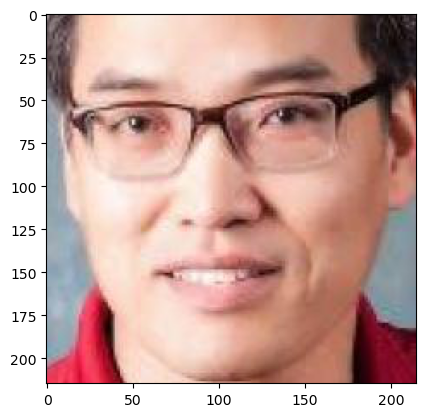

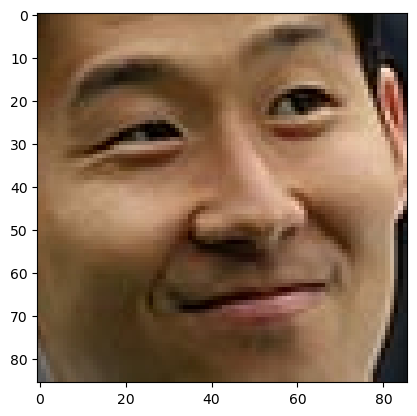

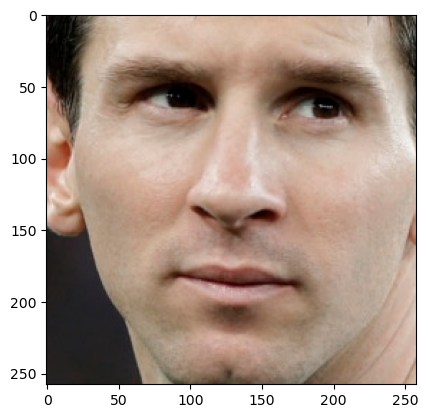

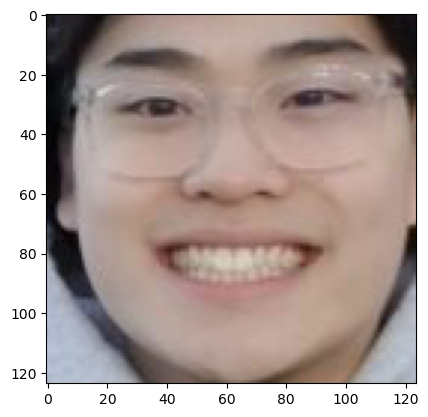

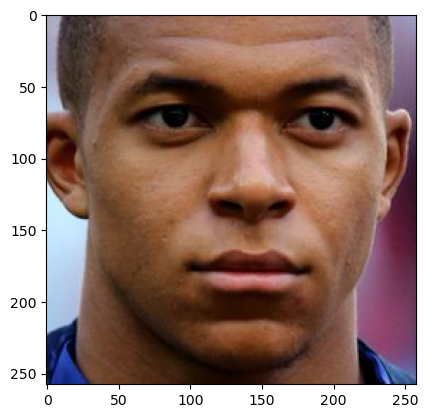

In [127]:
crop_images = []
for i, image in enumerate(test_img_list):
    img = Image.open(image)
    dets = detector(np.array(img))
    if len(dets) == 1:
        det = dets[0]

        x1 = det.left()
        y1 = det.top()
        x2 = det.right()
        y2 = det.bottom()

        crop_img = img.crop((x1, y1, x2, y2))
        crop_image_filename = f'{test_img_path}/crop{i:02d}.jpg'
        crop_images.append(crop_image_filename)
        crop_img.save(crop_image_filename)
        plt.figure()
        plt.imshow(crop_img)
    else:
        print('No face or multiple faces found.')

In [128]:
crop_images

['test_images/crop00.jpg',
 'test_images/crop01.jpg',
 'test_images/crop02.jpg',
 'test_images/crop03.jpg',
 'test_images/crop04.jpg']

1/1 [==============================] - 0s 36ms/step
Overall performance of a person having face 0 as a soccer player is predicted as 68.20.
1/1 [==============================] - 0s 15ms/step
Overall performance of a person having face 1 as a soccer player is predicted as 62.93.
1/1 [==============================] - 0s 15ms/step
Overall performance of a person having face 2 as a soccer player is predicted as 64.60.
1/1 [==============================] - 0s 15ms/step
Overall performance of a person having face 3 as a soccer player is predicted as 62.38.
1/1 [==============================] - 0s 16ms/step
Overall performance of a person having face 4 as a soccer player is predicted as 64.27.

The best soccer player based on face features is face 0 with 68.20


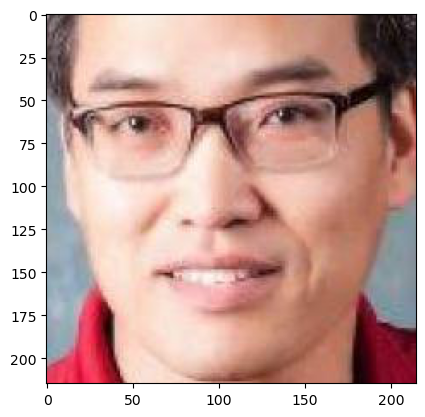

In [129]:
how_likely = []
for i, crop in enumerate(crop_images):

    emb = face_rec.calc_emb(crop)
    emb = np.expand_dims(emb, axis=0)
    emb.shape

    how_likely.append(model.predict(emb)[0][0])

    print('Overall performance of a person having face {:} as a soccer player is predicted as {:.2f}.'.format(i, how_likely[-1]))

best_idx = how_likely.index(max(how_likely))
print('\nThe best soccer player based on face features is face {:} with {:.2f}'.format(best_idx, how_likely[best_idx]))
img = Image.open(crop_images[best_idx])
plt.figure()
plt.imshow(img)

